# Loading the Data

In [ ]:
# Importing the dataset and indexing its data

import json
from datasets import load_dataset

# Load the dataset, trust_remote_code=True is needed to load the dataset from the remote repository.
dataset = load_dataset('dataset-download.py', trust_remote_code=True) 

doc_list = [dataset['train'][:20]] # Load the first 10 examples of the dataset
captions_list = doc_list[0]['en_captions']
#print(doc_list)  # Print the first example of the dataset

captions_list
#doc_list[0]['en_captions'][0]

# Sentences to use for the embeddings visualization
captions_list[1] # keyword "woman" (use this for now since it already has 6 sentences)
#captions_list[3] # keyword "dog" (might not be needed but I'm keeping it here just in case)

['The video starts with a title logo sequence.',
 ' A man and woman are in a living room demonstrating exercises.',
 ' The woman lays on the ground.',
 " The man starts pointing to different areas of the woman's body as she does an exercise.",
 ' The woman begins to do small sit ups.',
 ' The woman ends with a final title logo sequence.']

# Transformer Encoder

This notebook covers our understanding of the Tranformer Architecture as required in section 2.5


In [19]:
import torch

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import logging
logging.set_verbosity_warning()

import numpy as np
import pprint

from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



## Loading the Models


In [ ]:
#model_cross_encoder_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2' # Cross-Encoder Model
#model_path = 'nboost/pt-bert-base-uncased-msmarco'
model_path ='deepset/roberta-base-squad2'

CLS_token = "[CLS]"
SEP_token = "[SEP]"
#model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, output_hidden_states=True)
#model.eval() # Set the model to evaluation mode. This is important for models that have dropout layers, as it ensures that they are not used during inference.
# After loading the model, you can inspect its architecture. Typically, each model is composed by the embedding layer, the self-attention layers and the output layers. The output layer is always task specific. 
model

Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [55]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
    
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


In [56]:
# Only using one sentence for now, there is no question - answer sentences because it's a captions dataset...
sentence = "".join(captions_list[1])
inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)


In [57]:
with torch.no_grad():
    outputs = model(**inputs)

attention = outputs.attentions
hidden_states = outputs.hidden_states

## Visualization of embeddings / Contextual Embeddings

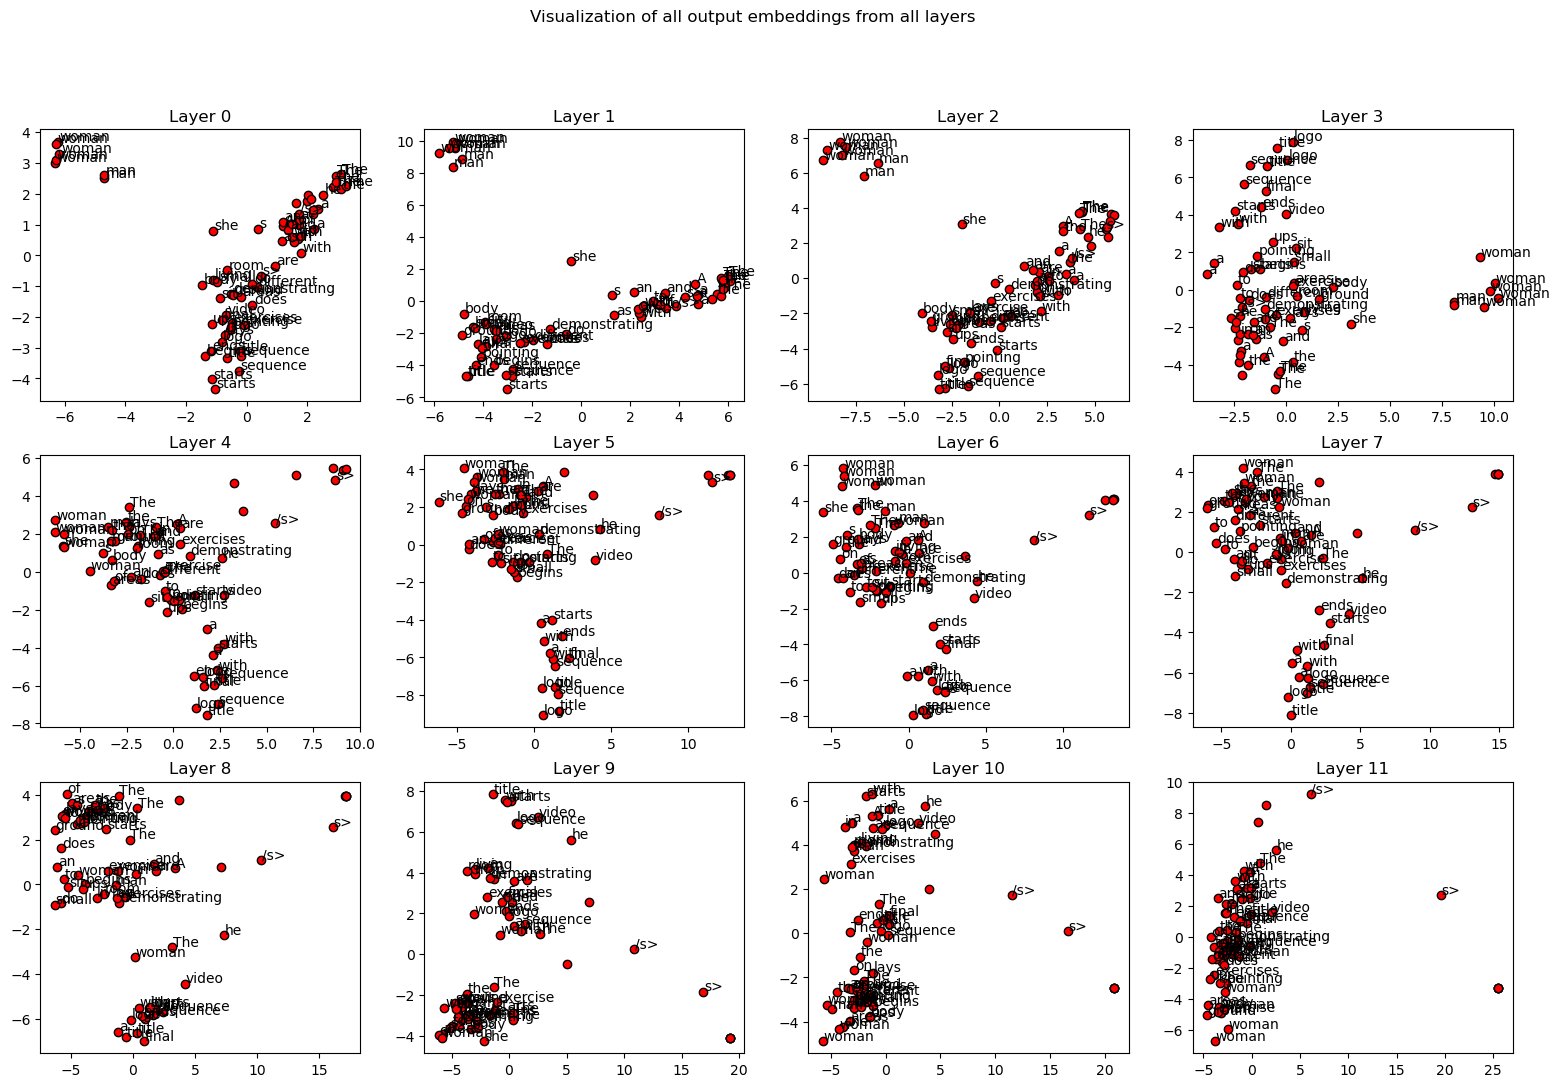

In [58]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word[1:])
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

# Positional Embeddings

Consider a text encoder. Insert a sequence of text with the 
same word repeated 20 times. Visualize the embeddings and the distance across all 
tokens. Discuss what you observe.

In [69]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_cross_encoder_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2' # Cross-Encoder Model
CLS_token = "[CLS]"
SEP_token = "[SEP]"

tokenizer = AutoTokenizer.from_pretrained(model_cross_encoder_path)
config = AutoConfig.from_pretrained(model_cross_encoder_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_cross_encoder_path, output_hidden_states=True)

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

# Tokenization of the repeated words sentence

In [70]:
# Creating the sequence of text with the same word 20 times
repeated_words_sentence = "test " * 20

# Tokenizing the sentence
inputs = tokenizer(repeated_words_sentence, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Running the sentence through the model
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states

# Pick the layer to visualize the embeddings
#hidden_states[0] is after token+position embeddings but before any transformer blocks
#hidden_states[1] is after the first transformer layer

# Distance across tokens

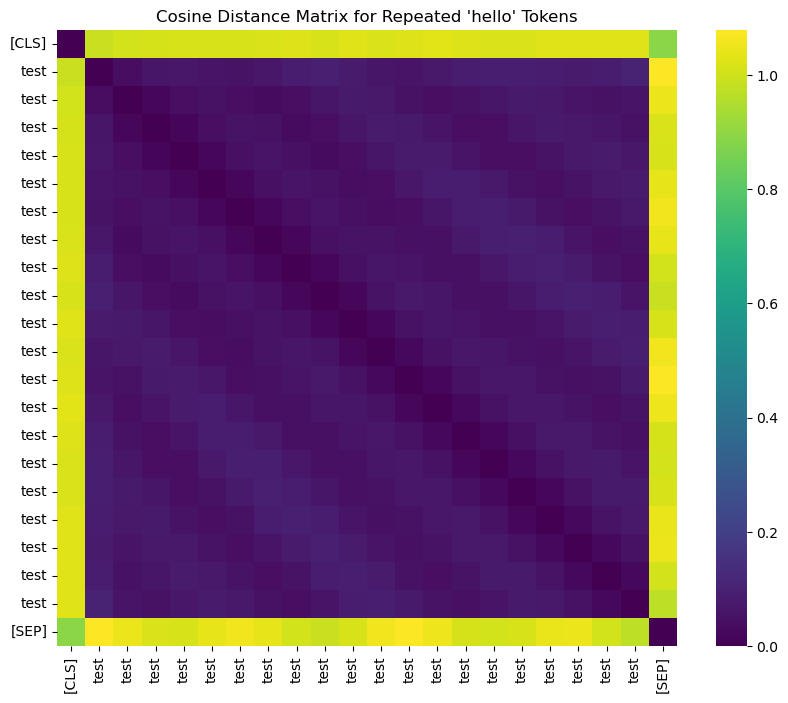

In [71]:
embeddings = hidden_states[0][0].numpy()

# Compute the distances
distances = cosine_distances(embeddings)

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(distances, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title("Cosine Distance Matrix for Repeated 'hello' Tokens")
plt.show()

# Embeddings Visualization

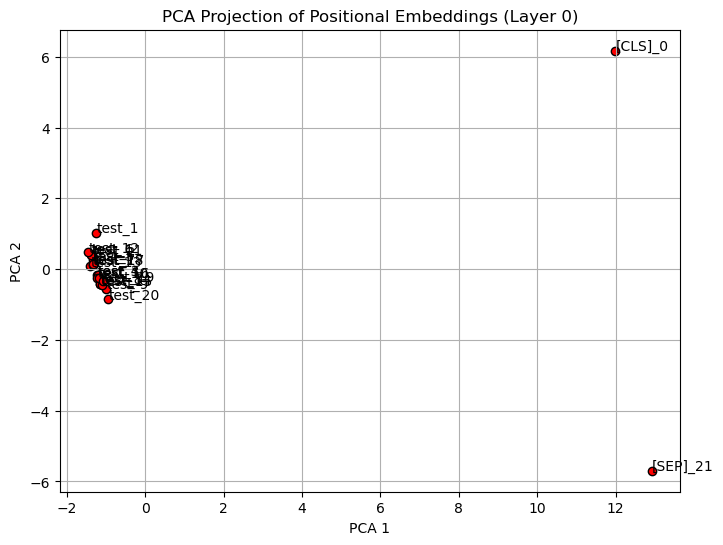

In [72]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='red', edgecolors='k')

for i, token in enumerate(tokens):
    plt.text(reduced_embeddings[i, 0]+0.01, reduced_embeddings[i, 1]+0.01, f"{token}_{i}")

plt.title("PCA Projection of Positional Embeddings (Layer 0)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


# Self-Attention

Examine the self-attention mecanism of a transformer cross-encoder.
Repeate with a dual encoder. Do a critical analysis of the observations

## Cross-Encoder Sections

In [74]:
# Here we are using the model above, a cross-encoder

model_cross_encoder_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2' # Cross-Encoder Model
CLS_token = "[CLS]"
SEP_token = "[SEP]"

tokenizer_cross = AutoTokenizer.from_pretrained(model_cross_encoder_path)
config_cross = AutoConfig.from_pretrained(model_cross_encoder_path,  output_hidden_states=True, output_attentions=True)  
model_cross = AutoModel.from_pretrained(model_cross_encoder_path, output_hidden_states=True)

# Sentences definition and running them through the model
sentence_a = "A question would go here?"
sentence_b = "The answer to that question would go here."
inputs = tokenizer_cross.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer_cross.convert_ids_to_tokens(input_id_list)

with torch.no_grad():
    outputs = model_cross(**inputs, output_attentions = True) # we need to have output_attentions = True, otherwise the cell below will not run

attention = outputs.attentions
hidden_states = outputs.hidden_states

In [75]:
# Token Specific Visualization of Self-Attention
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

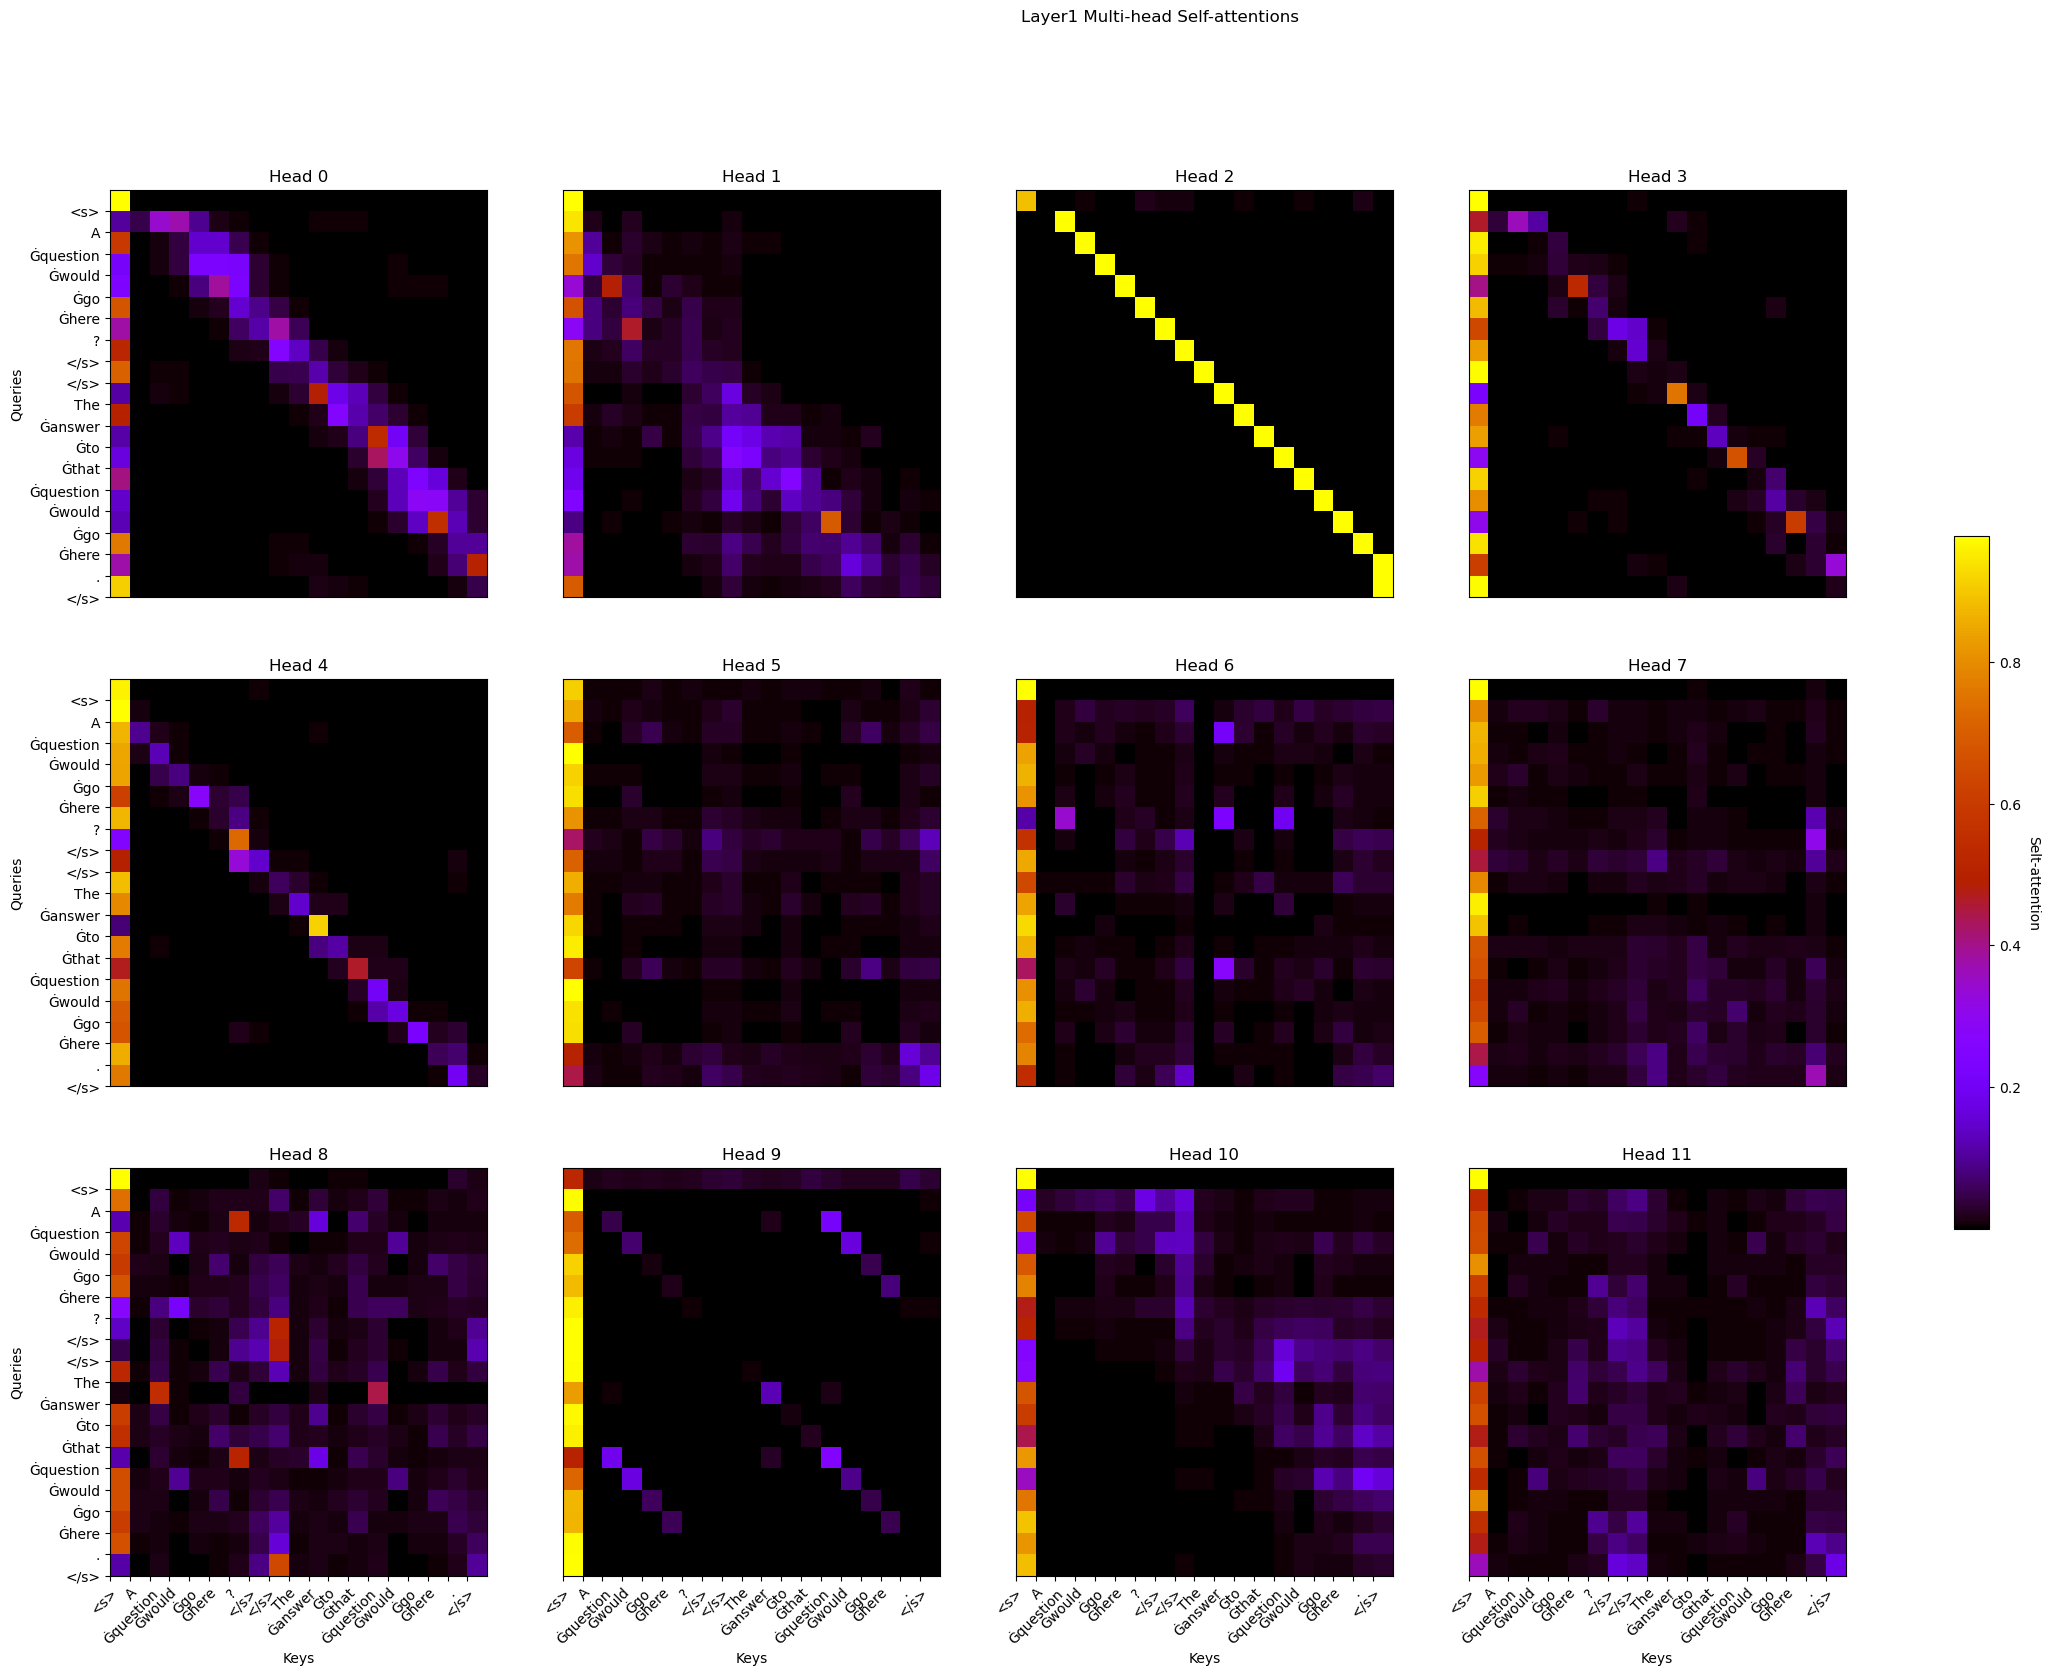

In [67]:
# Visualization of all the attention heads in one layer

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*6)
fig.set_figwidth(cols*6+4)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention = attention[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows-1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

In [68]:
# Visualization of self-attention in all layers and heads
model_view(attention, tokens)

<IPython.core.display.Javascript object>

## Dual-Encoder Sections

In [77]:
# Here we are using the model above, a cross-encoder

model_dual_encoder_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2' # Cross-Encoder Model
CLS_token = "[CLS]"
SEP_token = "[SEP]"

tokenizer_dual = AutoTokenizer.from_pretrained(model_dual_encoder_path)
config_dual = AutoConfig.from_pretrained(model_dual_encoder_path,  output_hidden_states=True, output_attentions=True)  
model_dual = AutoModel.from_pretrained(model_dual_encoder_path, output_hidden_states=True)

# Sentences definition and running them through the model
sentence_a = "A question would go here?"
sentence_b = "The answer to that question would go here."
inputs = tokenizer_dual.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer_dual.convert_ids_to_tokens(input_id_list)

with torch.no_grad():
    outputs = model_dual(**inputs, output_attentions = True) # we need to have output_attentions = True, otherwise the cell below will not run

attention = outputs.attentions
hidden_states = outputs.hidden_states